In [37]:
ls ../test-data/

2014-head.txt           EQY_US_ALL_BBO_20150731.zip@
2015-head.txt           small_test_data_public.h5
EQY_US_ALL_BBO_201111@  small_test_data_public.zip
EQY_US_ALL_BBO_201402@


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import tables as tb

In [3]:
import h5py
import dask.dataframe as dd
import dask.bag as db

In [4]:
import blaze

In [5]:
fname = '../test-data/EQY_US_ALL_BBO_201402/EQY_US_ALL_BBO_20140206.h5'
max_sym = '/SPY/no_suffix'

In [65]:
fname = '../test-data/small_test_data_public.h5'
max_sym = '/IXQAJE/no_suffix'

In [43]:
# by default, this will be read-only
taq_tb = tb.open_file(fname)

In [44]:
%%time
rec_counts = {curr._v_pathname: len(curr) 
              for curr in taq_tb.walk_nodes('/', 'Table')}

CPU times: user 952 ms, sys: 32.2 ms, total: 984 ms
Wall time: 1.29 s


In [45]:
# What's our biggest table? (in bytes)
max(rec_counts.values()) * 91 / 2 ** 20 # I think it's 91 bytes...

0.0794076919555664

Anyway, under a gigabyte. So, nothing to worry about even if we have 24 cores.

In [46]:
# But what symbol is that?
max_sym = None
max_rows = 0
for sym, rows in rec_counts.items():
    if rows > max_rows:
        max_rows = rows
        max_sym = sym

In [47]:
max_sym, max_rows

('/IXQAJE/no_suffix', 915)

Interesting... the S&P 500 ETF

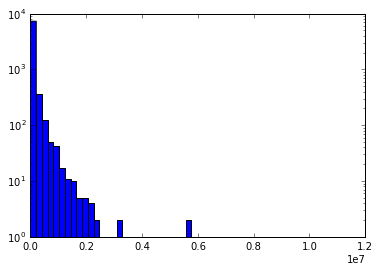

In [14]:
# Most symbols also have way less rows - note this is log xvals
plt.hist(list(rec_counts.values()), bins=50, log=True)
plt.show()

## Doing some compute

We'll use a "big" table to get some sense of timings

In [49]:
spy = taq_tb.get_node(max_sym)

In [16]:
# PyTables is record oriented...
%timeit np.mean(list(x['Bid_Price'] for x in spy.iterrows()))

1 loop, best of 3: 7.62 s per loop


In [50]:
# But this is faster...
%timeit np.mean(spy[:]['Bid_Price'])

The slowest run took 383.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 47.6 µs per loop


In [51]:
np.mean(spy[:]['Bid_Price'])

18.500255081967214

# Using numexpr?

numexpr is currently not set up to do reductions via HDF5. I've opened an issue here:
https://github.com/PyTables/PyTables/issues/548

In [14]:
spy_bp = spy.cols.Bid_Price

In [15]:
# this works...
np.mean(spy_bp)

176.82760773125673

In [51]:
# But it can't use numexpr
expr = tb.Expr('sum(spy_bp)')

In [61]:
# You can use numexpr to get the values of the column... but that's silly
# (sum doesn't work right, and the axis argument is non-functional)
%timeit result = expr.eval().mean()

1 loop, best of 3: 3.62 s per loop


In [60]:
tb.Expr('spy_bp').eval().mean()

176.82760773125673

# h5py

In [52]:
taq_tb.close()

In [6]:
%%time
spy_h5py = h5py.File(fname)[max_sym]

CPU times: user 1.64 ms, sys: 1.92 ms, total: 3.55 ms
Wall time: 3.36 ms


In [123]:
np.mean(spy_h5py['Bid_Price'])

18.500255081967214

h5py may be a *touch* faster than pytables for this kind of usage. But why does pandas use pytables?

In [55]:
%%timeit
np.mean(spy_h5py['Bid_Price'])

The slowest run took 5.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 253 µs per loop


# Dask 

It seems that there should be no need to, e.g., use h5py - but dask's read_hdf doens't seem to be working nicely...

In [28]:
taq_tb.close()

spy_h5py = h5py.File(fname)[max_sym]

In [56]:
store = pd.HDFStore(fname)

In [31]:
store = pd.HDFStore('../test-data/')

In [62]:
# this is a fine way to iterate over our datasets (in addition to what's available in PyTables and h5py)
it = store.items()

In [101]:
key, tab = next(it)

In [102]:
tab

/KSJXFM/no_suffix (Table(33,), fletcher32, shuffle, blosc:lz4hc(9)) ''
  description := {
  "Time": Float64Col(shape=(), dflt=0.0, pos=0),
  "hour": Int8Col(shape=(), dflt=0, pos=1),
  "minute": Int8Col(shape=(), dflt=0, pos=2),
  "msec": UInt16Col(shape=(), dflt=0, pos=3),
  "Exchange": StringCol(itemsize=1, shape=(), dflt=b'', pos=4),
  "Bid_Price": Float64Col(shape=(), dflt=0.0, pos=5),
  "Bid_Size": Int32Col(shape=(), dflt=0, pos=6),
  "Ask_Price": Float64Col(shape=(), dflt=0.0, pos=7),
  "Ask_Size": Int32Col(shape=(), dflt=0, pos=8),
  "Quote_Condition": StringCol(itemsize=1, shape=(), dflt=b'', pos=9),
  "Market_Maker": StringCol(itemsize=4, shape=(), dflt=b'', pos=10),
  "Bid_Exchange": StringCol(itemsize=1, shape=(), dflt=b'', pos=11),
  "Ask_Exchange": StringCol(itemsize=1, shape=(), dflt=b'', pos=12),
  "Sequence_Number": Int64Col(shape=(), dflt=0, pos=13),
  "National_BBO_Ind": StringCol(itemsize=1, shape=(), dflt=b'', pos=14),
  "NASDAQ_BBO_Ind": StringCol(itemsize=1, shape

In [106]:
# The columns argument doesn't seem to work...
store.select(max_sym, columns=['Bid_Price']).head()

,Time,hour,minute,msec,Exchange,Bid_Price,Bid_Size,Ask_Price,Ask_Size,Quote_Condition,...,NASDAQ_BBO_Ind,Quote_Cancel_Correction,Source_of_Quote,Retail_Interest_Indicator_RPI,Short_Sale_Restriction_Indicator,LULD_BBO_Indicator_CQS,LULD_BBO_Indicator_UTP,FINRA_ADF_MPID_Indicator,SIP_generated_Message_Identifier,National_BBO_LULD_Indicator
0,1.391697e+09,9,28,20433,P,18.8799,37,17.2773,92,R,...,2,,C,,,,,,,
1,1.391697e+09,9,30,221,Z,18.1199,0,19.0143,40,R,...,2,,C,,,,,,,
2,1.391697e+09,9,30,4263,Y,18.9737,35,18.0378,14,R,...,2,A,C,B,,,,,,
3,1.391697e+09,9,31,8022,P,18.6253,0,17.0418,38,R,...,2,,C,,,,,,,
4,1.391697e+09,9,32,16402,N,19.0082,0,16.9483,20,R,...,2,,C,,,,,,,


In [109]:
# columns also doesn't work here...
pd.read_hdf(fname, max_sym, columns=['Bid_Price']).head()

,Time,hour,minute,msec,Exchange,Bid_Price,Bid_Size,Ask_Price,Ask_Size,Quote_Condition,...,NASDAQ_BBO_Ind,Quote_Cancel_Correction,Source_of_Quote,Retail_Interest_Indicator_RPI,Short_Sale_Restriction_Indicator,LULD_BBO_Indicator_CQS,LULD_BBO_Indicator_UTP,FINRA_ADF_MPID_Indicator,SIP_generated_Message_Identifier,National_BBO_LULD_Indicator
0,1.391697e+09,9,28,20433,P,18.8799,37,17.2773,92,R,...,2,,C,,,,,,,
1,1.391697e+09,9,30,221,Z,18.1199,0,19.0143,40,R,...,2,,C,,,,,,,
2,1.391697e+09,9,30,4263,Y,18.9737,35,18.0378,14,R,...,2,A,C,B,,,,,,
3,1.391697e+09,9,31,8022,P,18.6253,0,17.0418,38,R,...,2,,C,,,,,,,
4,1.391697e+09,9,32,16402,N,19.0082,0,16.9483,20,R,...,2,,C,,,,,,,


In [110]:
spy_dd = dd.read_hdf(fname, max_sym)

ValueError: Empty data passed with indices specified.

In [120]:
spy_dd = dd.read_hdf(fname + ':' + max_sym)

TypeError: read_hdf() missing 1 required positional argument: 'key'

In [7]:
# So we use h5py
spy_dask = dd.from_array(spy_h5py)

In [8]:
mean_job = spy_dask['Bid_Price'].mean()

In [127]:
mean_job.compute()

18.500255081967214

In [9]:
# This is appreciably slower than directly computing the mean w/ numpy
%timeit mean_job.compute()

1 loop, best of 3: 9.55 s per loop


## Dask for an actual distributed task (but only on one file for now)

In [66]:
from dask import delayed

@delayed
def mean_column(key, data, column='Bid_Price'):
    return blaze.data(data)[column].mean()

class DDFs:
    # A (key, table) list
    datasets = []
    dbag = None

    def __init__(self, h5fname):
        h5in = h5py.File(h5fname)
        h5in.visititems(self.collect_dataset)
        # self.dbag = db.from_sequence(self.datasets)
    
    def collect_dataset(self, key, table):
        if isinstance(table, h5py.Dataset):
            self.datasets.append(dd.from_array(table)['Bid_Price'].mean())
            # self.datasets[key] = mean_column(key, table)
            
    def compute_mean(self):
        self.mean_computer = self.dbag.map(lambda x: (x[0], dd.from_array(x[1])['Bid_Price'].mean()))
        # self.means[key] = blaze.data(table)['Bid_Price'].mean()    
        # self.means = means.compute()

In [89]:
df = dd.from_pandas(pd.DataFrame({'a': [1,2]}), npartitions=1)
numbers = [df['a'].mean() for _ in range(2)]
dd.compute(numbers)

([<dask.dataframe.core.Scalar at 0x7f91d1523978>,
  <dask.dataframe.core.Scalar at 0x7f91d1523a58>],)

In [91]:
from dask import delayed

@delayed
def mean(data):
    sum(data)/len(data)
    
delayed_numbers = [mean([1,2]) for _ in range(2)]

In [101]:
dask.compute(delayed_numbers)

([Delayed('mean-0e0a0dea-fa92-470d-b06e-b639fbaacae3'),
  Delayed('mean-89f2e361-03b6-4279-bef7-572ceac76324')],)

In [100]:
dask.multiprocessing.get(delayed_numbers, 0)
#(delayed_numbers)

TypeError: list indices must be integers or slices, not Delayed

In [70]:
%%time
ddfs = DDFs(fname)

CPU times: user 256 ms, sys: 6.93 ms, total: 263 ms
Wall time: 260 ms


In [72]:
ddfs.datasets[:5]

In [75]:
dbag = db.from_sequence(ddfs.datasets)

In [76]:
results = dbag.compute()

In [78]:
results[0]

In [63]:
dd.compute(ddfs.datasets)

([<dask.dataframe.core.Scalar at 0x7f91dac9fb70>,
  ...],)

In [46]:
next(iter(ddfs.datasets.items()))

('GPT/PRA', Delayed('mean_column-7db88a75-7277-4540-8214-19067dfd04dd'))

In [47]:
from dask import multiprocessing as mp

In [49]:
mp.get(ddfs.datasets, 'GPT/PRA')

Delayed('mean_column-7db88a75-7277-4540-8214-19067dfd04dd')

In [34]:
computed_ds = dd.compute(ddfs.datasets)

In [55]:
import dask

In [56]:
dask.compute?

In [36]:
ddfs.datasets[0].compute()

('A/no_suffix', 57.60852492511026)

In [81]:
%%time
ddfs.compute_mean()

CPU times: user 3.29 ms, sys: 1.87 ms, total: 5.17 ms
Wall time: 4.66 ms


In [83]:
# This ain't working either...
res = ddfs.mean_computer.compute()

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
KeyError: 139656117072712
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 197, in h5py._objects.ObjectID.__dealloc__ (-------src-dir-------/h5py/_objects.c:4494)
Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 197, in h5py._objects.ObjectID.__dealloc__ (-------src-dir-------/h5py/_objects.c:4494)
KeyError: 139656117072712
Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 197, in h5py._objects.ObjectID.__dealloc__ (-------src-dir-------/h5py/_objects.c:4494)
KeyError: 139656117072712
Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 197, in h5py._objects.ObjectID.__dealloc__ (-------src-dir-------/h5py/_objects.c:4494)
KeyError: 139656117072712
Exception ignored in: 'h5py._objects

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/dav/miniconda3/envs/TAQ/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/dav/miniconda3/envs/TAQ/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/dav/miniconda3/envs/TAQ/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
1 + 2

# Blaze?

Holy crap!

In [19]:
spy_blaze = blaze.data(spy_h5py)

In [20]:
%time 
spy_blaze['Ask_Price'].mean()

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 21 µs


176.84371349272752

In [16]:
taq_tb = tb.open_file(fname)
spy_tb = taq_tb.get_node(max_sym)

In [17]:
spy_blaze = blaze.data(spy_tb)

In [18]:
%time spy_blaze['Bid_Price'].mean()

CPU times: user 0 ns, sys: 978 µs, total: 978 µs
Wall time: 647 µs


176.82760773125673

In [21]:
taq_tb.close()

## Read directly with Blaze

Somehow this is not as impressive

In [15]:
%%time
blaze_h5_file = blaze.data(fname)

# This is rather nice
blaze_h5_file.SPY.no_suffix.Bid_Price.mean()

CPU times: user 12.7 s, sys: 1.05 s, total: 13.7 s
Wall time: 59.9 s


In [39]:
blaze_h5_file.ZFKOJB.no_suffix.Bid_Price.mean()

18.475936662749703

# Do some actual compute with Blaze

In [38]:
taq_h5py = h5py.File(fname)

In [50]:
class SymStats:
    means = {}

    def compute_stats(self, key, table):
        if isinstance(table, h5py.Dataset):
            self.means[key] = blaze.data(table)['Bid_Price'].mean()    

In [51]:
ss = SymStats()

In [52]:
%time taq_h5py.visititems(ss.compute_stats)

CPU times: user 11.2 s, sys: 1.74 s, total: 12.9 s
Wall time: 51.8 s


In [56]:
means = iter(ss.means.items())

In [65]:
next(means)

('SYT/no_suffix', 67.53453714044622)

In [67]:
ss.means['SPY/no_suffix']

176.82760773125673

# Pandas? 

### To load with Pandas, you need to close the pytables session

In [40]:
taq_tb.close()

In [7]:
# Pandas has optimizations it likes to do with 
%timeit spy_df = pd.read_hdf(fname, max_sym)

10 loops, best of 3: 32.6 ms per loop


In [9]:
# Actually do it
spy_df = pd.read_hdf(fname, max_sym)

In [10]:
# This is fast, but loading is slow...
%timeit spy_df.Bid_Price.mean()

The slowest run took 6.25 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 57.8 µs per loop
